In [55]:
import pyodbc    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.metrics import confusion_matrix,silhouette_samples, silhouette_score
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')


# Getting Data
## Instead of storing data in a csv file and call it, get data directly from SQL server

In [2]:
serverprop = ("Driver={SQL Server Native Client 11.0};"
            "Server=XYZ;"
            "Database=XYZ;"
            "UID=XYZ;"
            "PWD=XYZ;")
stp = pyodbc.connect(serverprop)

In [3]:
query1=" select Moshtary,DarkhastFaktor,TarikhForm,Kcode,Fee,( sum(SalesQty)- sum(ReturnQty)) as NetQty from \
    (SELECT sdf.ccMoshtary as Moshtary,sdf.ccDarkhastFaktor as DarkhastFaktor,wk.TarikhForm as TarikhForm,wkala.CodeMother as Kcode,wks.Gheymat3 as Fee, sum(wks.Tedad3)as SalesQty, 0 as ReturnQty\
     FROM Warehouse.Kardex as wk left outer join Warehouse.KardexSatr as wks on wks.ccKardex=wk.ccKardex\
    left outer join Sales.darkhastfaktor as sdf on sdf.ccDarkhastFaktor=wk.ccRefrence\
    left outer join Warehouse.Kala as wkala on wkala.ccKalaCode=wks.ccKalaCode\
    where wk.CodeNoeForm=8 and wks.CodeNoeKala=1 and wk.CodeVazeiat=99\
    group by sdf.ccMoshtary,sdf.ccDarkhastFaktor,wk.TarikhForm,wkala.CodeMother,wks.Gheymat3\
    Union All\
    SELECT sdf.ccMoshtary,sdf.ccDarkhastFaktor,wk.TarikhForm,wkala.CodeMother,wks.Gheymat3,0 as SalesQty,sum(wks.Tedad3)as ReturnQty\
    FROM Warehouse.Kardex as wk left outer join Warehouse.KardexSatr as wks on wks.ccKardex=wk.ccKardex\
    left outer join Sales.darkhastfaktor as sdf on sdf.ccDarkhastFaktor=wk.ccRefrence\
    left outer join Warehouse.Kala as wkala on wkala.ccKalaCode=wks.ccKalaCode\
    where wk.CodeNoeForm in (10,57) and wks.CodeNoeKala=1 and wk.CodeVazeiat=99\
    group by sdf.ccMoshtary,sdf.ccDarkhastFaktor,wk.TarikhForm,wkala.CodeMother,wks.Gheymat3) as kol\
    where TarikhForm between '2022-03-20' and '2022-10-23'\
    group by Moshtary,DarkhastFaktor,TarikhForm,Kcode,Fee"


In [4]:
data = pd.read_sql( query1 , stp)

C:\Users\h.nazari\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
#dataset size
data.shape

(811016, 6)

In [6]:
data.head()

Moshtary  DarkhastFaktor              TarikhForm Kcode       Fee  NetQty
0   79707.0       1173148.0 2022-05-16 11:07:52.400  3061  369000.0     3.0
1   91387.0       1177576.0 2022-05-21 20:37:30.413  3060  164000.0     5.0
2   94634.0       1184251.0 2022-05-30 19:05:27.943  3062  336200.0     5.0
3   79069.0       1189032.0 2022-06-08 14:05:05.710  3075  303400.0    10.0
4   94422.0       1258809.0 2022-08-29 09:21:20.067  3545   92742.0    10.0

In [7]:
data.columns

Index(['Moshtary', 'DarkhastFaktor', 'TarikhForm', 'Kcode', 'Fee', 'NetQty'], dtype='object')

# Features Descriptions

* Moshtary : CustomerID
* DarkhastFaktor : Invoice Number
* TarikhForm : Invoice Date
* Kcode : Product Code
* Fee : Unit Price
* NetQty : Sales Quantity

In [8]:
data.columns=['CustomerID', 'InvoiceNumber', 'InvoiceDate', 'ProductCode','UnitPrice','SalesQuantity']

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811016 entries, 0 to 811015
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   CustomerID     810857 non-null  float64       
 1   InvoiceNumber  810857 non-null  float64       
 2   InvoiceDate    811016 non-null  datetime64[ns]
 3   ProductCode    811016 non-null  object        
 4   UnitPrice      811016 non-null  float64       
 5   SalesQuantity  811016 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 37.1+ MB


In [10]:
#Descriptive statistics of dataset 

data.describe()

CustomerID  InvoiceNumber     UnitPrice  SalesQuantity
count  810857.000000   8.108570e+05  8.110160e+05  811016.000000
mean    86457.909312   1.225106e+06  3.677111e+05      17.713466
std      5098.791937   4.981052e+04  4.254742e+05      64.015318
min     78642.000000   3.969960e+05  1.000000e+00   -6800.000000
25%     82056.000000   1.181502e+06  2.049180e+05       3.000000
50%     85790.000000   1.232272e+06  2.873300e+05       5.000000
75%     90871.000000   1.267799e+06  4.346000e+05      12.000000
max     95680.000000   1.301613e+06  1.490826e+07    6801.000000

In [78]:
data.nunique()

CustomerID        11301
InvoiceNumber    138882
InvoiceDate      146049
ProductCode         915
UnitPrice          1040
SalesQuantity      1029
days                193
cost              24941
date                193
dtype: int64

## Data Cleaning - Dealing with missing values

In [11]:
np.sum(data.isna())

CustomerID       159
InvoiceNumber    159
InvoiceDate        0
ProductCode        0
UnitPrice          0
SalesQuantity      0
dtype: int64

<AxesSubplot:>

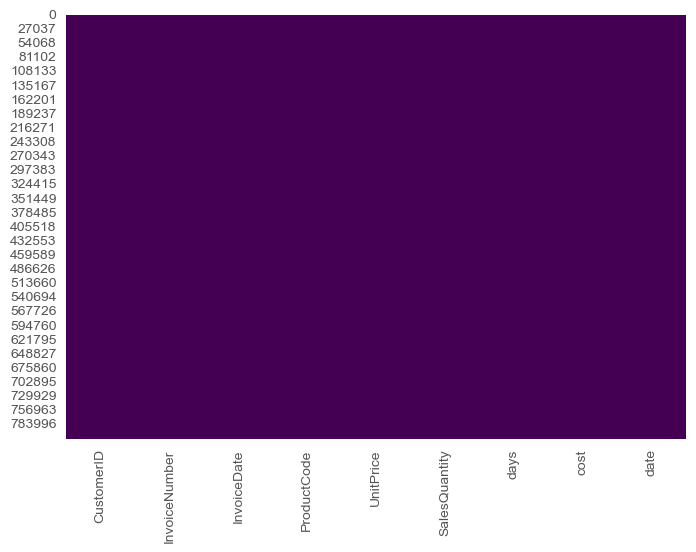

In [56]:
sns.heatmap(data.isnull(),cmap='viridis',cbar=False)

In [28]:
#rows containing missing value
data[data['CustomerID'].isna()]

CustomerID  InvoiceNumber             InvoiceDate ProductCode  \
674            NaN            NaN 2022-05-22 15:55:45.923        3105   
3419           NaN            NaN 2022-05-22 17:14:40.153        3017   
13927          NaN            NaN 2022-08-14 08:03:29.920        3086   
16815          NaN            NaN 2022-06-30 11:30:08.353        3155   
18776          NaN            NaN 2022-07-30 09:42:42.150        3012   
...            ...            ...                     ...         ...   
781686         NaN            NaN 2022-07-30 10:25:32.210        3023   
794941         NaN            NaN 2022-07-30 10:25:32.210        3083   
799136         NaN            NaN 2022-07-30 09:42:42.150        3109   
799486         NaN            NaN 2022-08-15 18:22:48.420        3564   
802998         NaN            NaN 2022-10-12 11:02:27.883        3104   

        UnitPrice  SalesQuantity  
674      271186.0           -4.0  
3419     220339.0          -11.0  
13927    738000.0          -10.0  
16815    451000.0         -112.0  
18776     82000.0           -2.0  
...           ...            ...  
781686    95120.0           -3.0  
794941   139400.0           -3.0  
799136    96760.0           -1.0  
799486   345000.0         -300.0  
802998   401800.0          -15.0  

[159 rows x 6 columns]

In [29]:
data.dropna(inplace=True)

# Feature Extraction
## Based on RFM model, we need to extract these 3 features (R-F-M) to use in k-means algorithm. But I'd like to improve the model by adding more features. I carried out some research and decided to add SKU.So, we will have 4 features:
### R (Recently): How recently did the customer purchase?
### F (Frequency ): How often do they purchase?
### M (Monetary Value): How much do they spend?
### SKU: How many distinct  products do they buy? 

In [32]:
#R (Recently)
data['InvoiceDate']=data['InvoiceDate'].agg(pd.Timestamp)
today=pd.Timestamp('2022-10-23')
data['days']=data['InvoiceDate'].agg(lambda x: (today-x).days)
Recency=data.groupby('CustomerID').days.min()

In [33]:
#F (Frequency )
data['cost']=data['UnitPrice']*data['SalesQuantity']
Montery=data.groupby('CustomerID').cost.sum()

In [34]:
#M (Monetary Value)
data['date']=data['InvoiceDate'].agg(lambda x:x.date())
Frequency11=data.groupby(['CustomerID','date']).cost.sum()
Frequency12=Frequency11.agg(lambda x:0 if x<0 else 1)
Frequency=Frequency12.groupby('CustomerID').agg(sum)

In [35]:
#SKU
sku1=data.groupby(['CustomerID','ProductCode']).SalesQuantity.sum()
sku2=sku1.agg(lambda x: 0 if x<0 else 1)
SKU=sku2.groupby('CustomerID').agg(sum)

In [36]:
# Concatenate all in one dataframe
X=pd.concat((pd.DataFrame(Recency),pd.DataFrame(Frequency),pd.DataFrame(Montery),pd.DataFrame(SKU)),axis=1)
X.columns=['R','F','M',"SKU"]
X.describe()

R             F             M           SKU
count  11301.000000  11301.000000  1.130100e+04  11301.000000
mean      26.277763     10.428015  3.471286e+08     48.194762
std       38.923054      7.786832  5.123475e+08     33.613401
min        0.000000      0.000000 -1.112400e+09      0.000000
25%        4.000000      5.000000  8.808256e+07     24.000000
50%       11.000000      9.000000  2.007243e+08     42.000000
75%       32.000000     14.000000  4.150226e+08     65.000000
max      202.000000     62.000000  1.335070e+10    321.000000

In [37]:
#Putt customers with zero or negative Montery in a class (E)
X_E=X.loc[X['M']<=0,:]
X=X.loc[X['M']>0,:]
X.describe()

R             F             M           SKU
count  11177.000000  11177.000000  1.117700e+04  11177.000000
mean      25.538427     10.529301  3.513838e+08     48.672184
std       37.885874      7.767346  5.133948e+08     33.471880
min        0.000000      1.000000  1.012840e+05      1.000000
25%        4.000000      5.000000  9.086218e+07     24.000000
50%       10.000000      9.000000  2.039608e+08     42.000000
75%       31.000000     15.000000  4.179634e+08     65.000000
max      202.000000     62.000000  1.335070e+10    321.000000

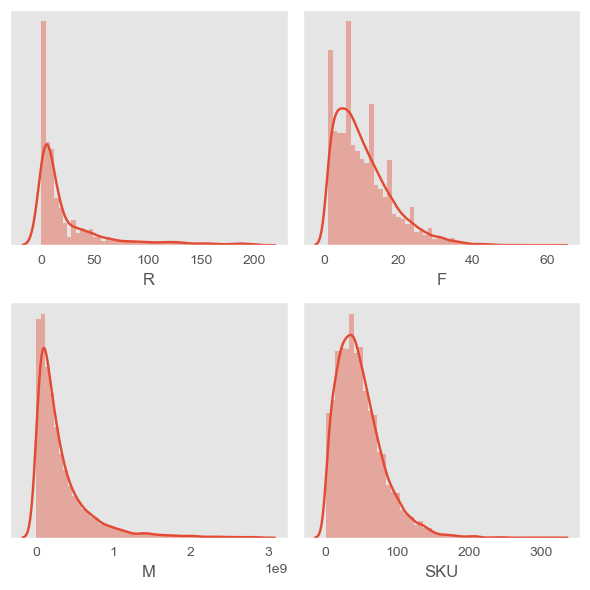

In [95]:
rows=2
cols=2

fig,ax=plt.subplots(nrows=rows,ncols=cols,figsize=(6,6))

col=X.columns
index=0

for i in range(rows):
    for j in range(cols):
        sns.distplot(X[col[index]],ax=ax[i][j])
        ax[i][j].grid()
        ax[i][j].set_yticks([])
        ax[i][j].set_ylabel("")
        index=index+1

plt.tight_layout()
plt.show()

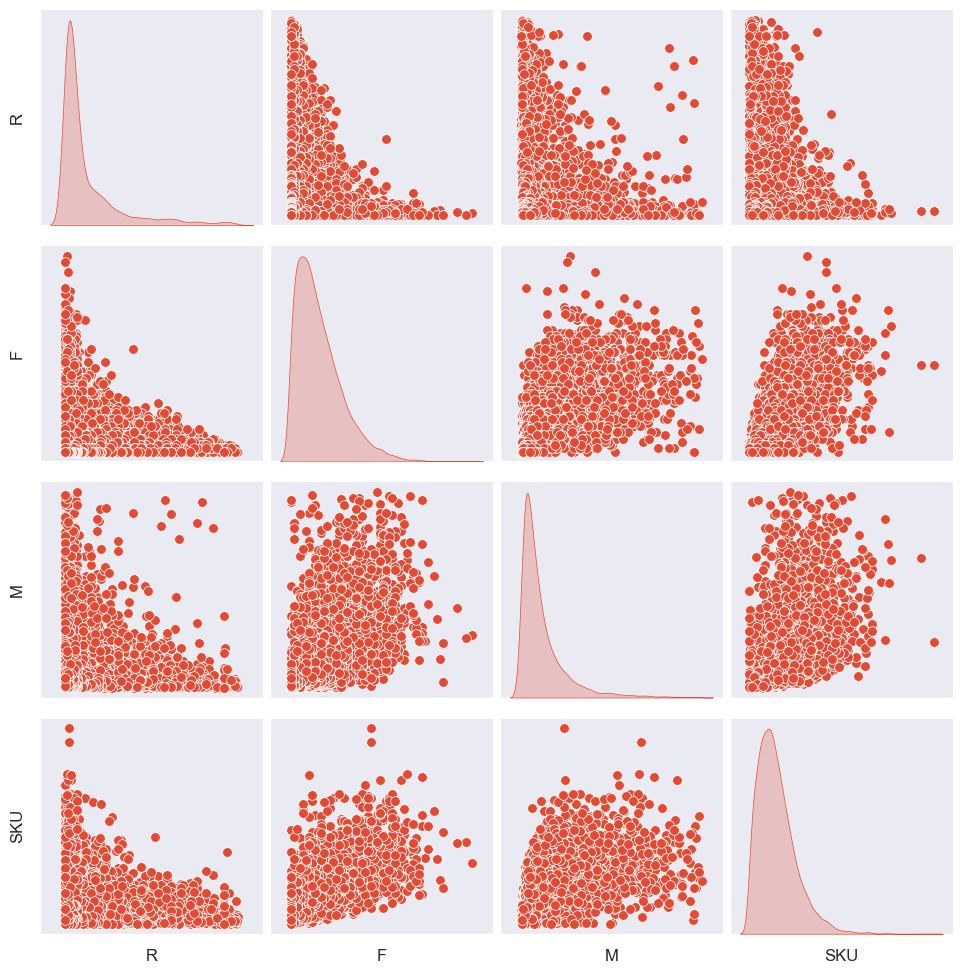

In [136]:
g1=sns.pairplot(X,diag_kind='kde')
g1.set(yticklabels=[])
g1.set(xticklabels=[])
sns.set_style("dark")

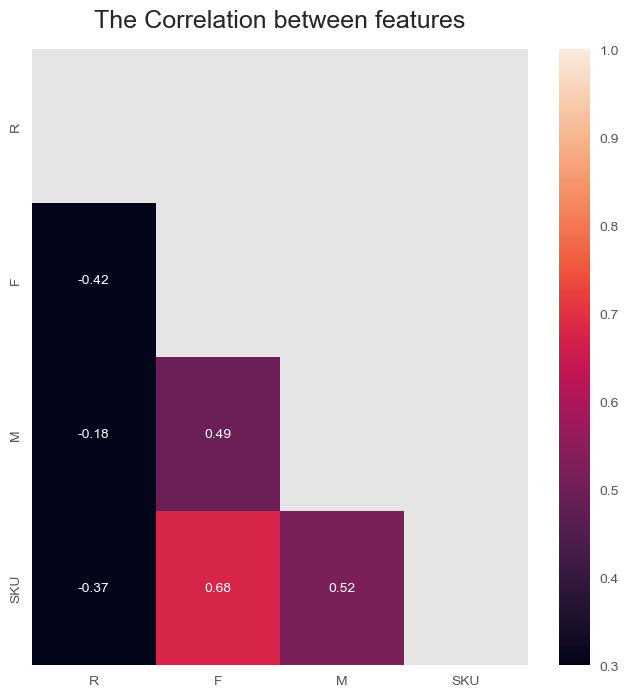

In [60]:
plt.figure(figsize=(8, 8))
mask = np.triu(np.ones_like(X.corr(), dtype=bool))
heatmap = sns.heatmap(X.corr(), mask=mask, vmin=0.3, vmax=1, annot=True)
heatmap.set_title('The Correlation between features', fontdict={'fontsize':18}, pad=16);

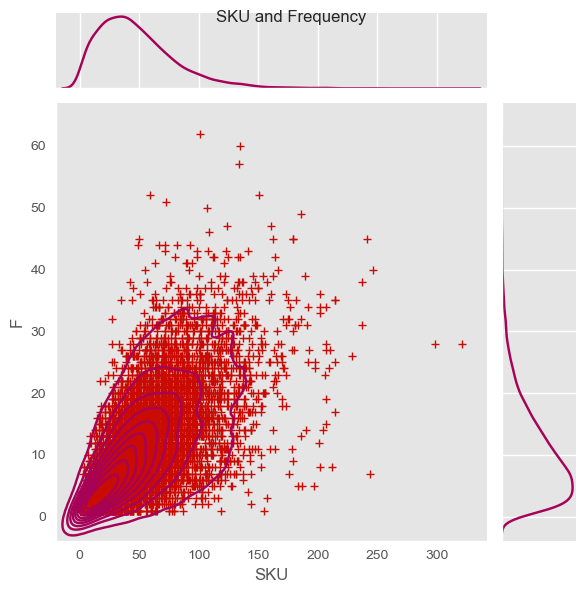

In [122]:
plt.style.use('ggplot')
g=sns.jointplot(X['SKU'],X['F'],kind='kde',color='m')
g.fig.suptitle('SKU and Frequency')
g.plot_joint(plt.scatter,c='r',s=40,linewidth=1,marker='+')
plt.grid()

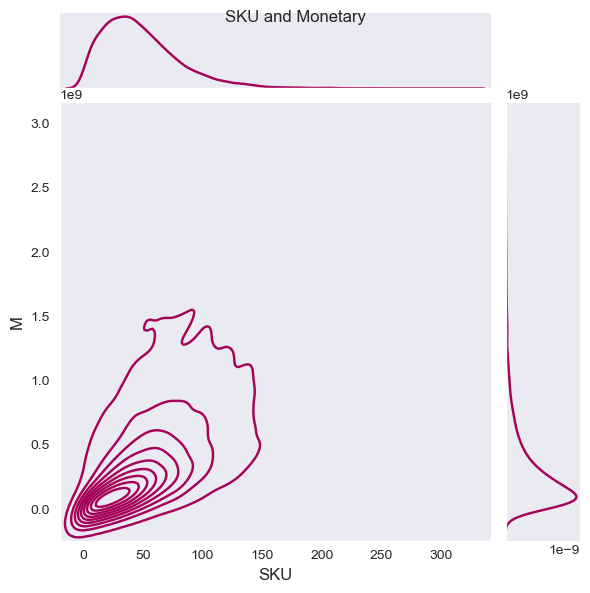

In [113]:
sns.jointplot(x=X['SKU'],y=X['M'],kind='kde',color='m').fig.suptitle('SKU and Monetary')
sns.set_style("dark", {'axes.grid' : False})

# Dealing with Outliers

<AxesSubplot:>

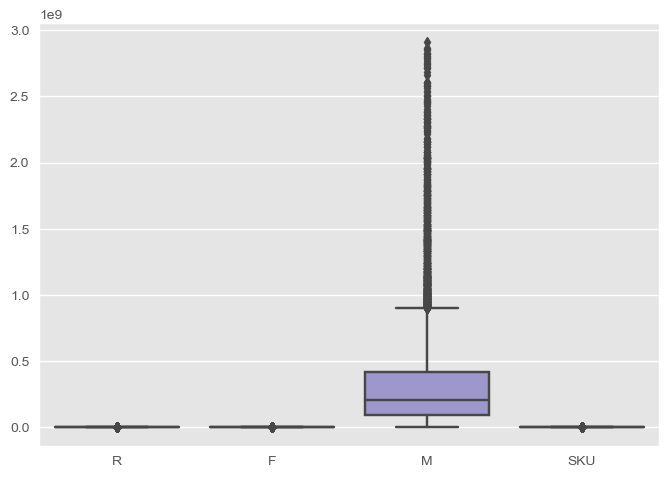

In [138]:
sns.boxplot(data=X)

<AxesSubplot:xlabel='M'>

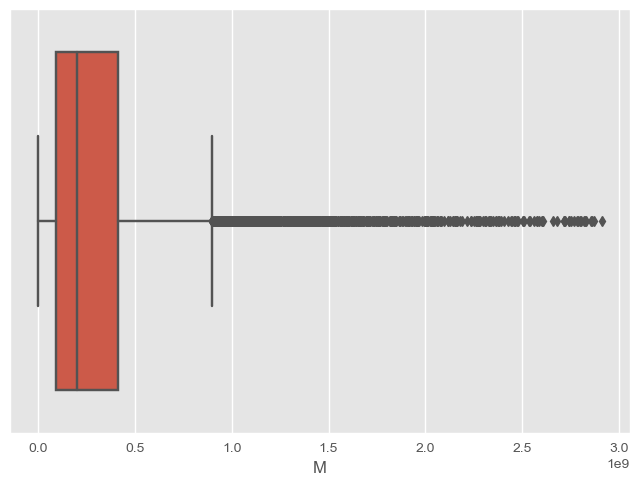

In [139]:
sns.boxplot(X['M'])

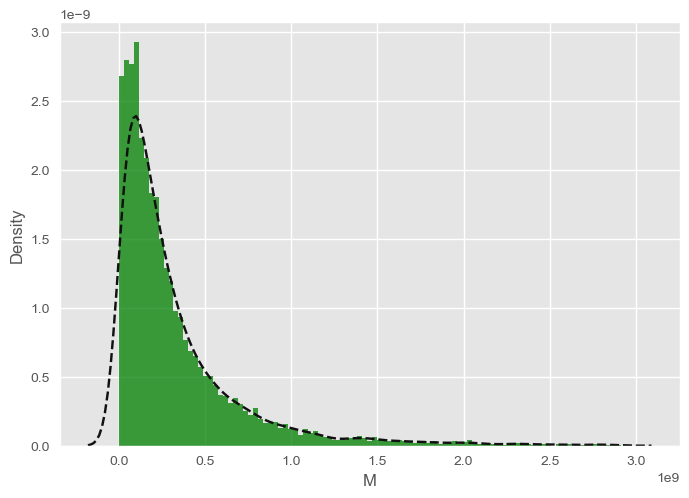

In [140]:
sns.histplot(X['M'],color='green',stat='density',edgecolor='none')
sns.kdeplot(X['M'],color='k',linestyle='--')
plt.show();

In [141]:
#1st method :Zscore

X=X[(np.abs(stats.zscore(X['M']))<5)]

#Put these customers in E cluster
X_low=X[stats.zscore(X['M'])<-5]

#Put these customers in VIP cluster
X_high=X[stats.zscore(X['M'])>5]

In [142]:
X_low.shape,X_high.shape

((0, 4), (25, 4))

In [143]:
# There are 2 other methods to deel with outliers
'''
#2nd method
q = X["M"].quantile(0.99)

q_low = X["M"].quantile(0.01)
q_hi  = X["M"].quantile(0.99)

X_onlyhifiltered=X[X["M"] < q]
X_filtered = X[(X["M"] < q_hi) & (X["M"] > q_low)]
X_low=X[(X['M']<q_low)]
X_hi=X[(X['M']>q_hi)]


#3rd method
q1=X['M'].quantile(0.25)
q3=X['M'].quantile(0.75)
IQR=q3-q1
low_range=q1-1.5*IQR
high_range=q3+1.5*IQR

X_low_range=X[X['M']<low_range]
X_high_range=X[X['M']>high_range]
'''

'\n#2nd method\nq = X["M"].quantile(0.99)\n\nq_low = X["M"].quantile(0.01)\nq_hi  = X["M"].quantile(0.99)\n\nX_onlyhifiltered=X[X["M"] < q]\nX_filtered = X[(X["M"] < q_hi) & (X["M"] > q_low)]\nX_low=X[(X[\'M\']<q_low)]\nX_hi=X[(X[\'M\']>q_hi)]\n\n\n#3rd method\nq1=X[\'M\'].quantile(0.25)\nq3=X[\'M\'].quantile(0.75)\nIQR=q3-q1\nlow_range=q1-1.5*IQR\nhigh_range=q3+1.5*IQR\n\nX_low_range=X[X[\'M\']<low_range]\nX_high_range=X[X[\'M\']>high_range]\n'

# Customer Segmentation

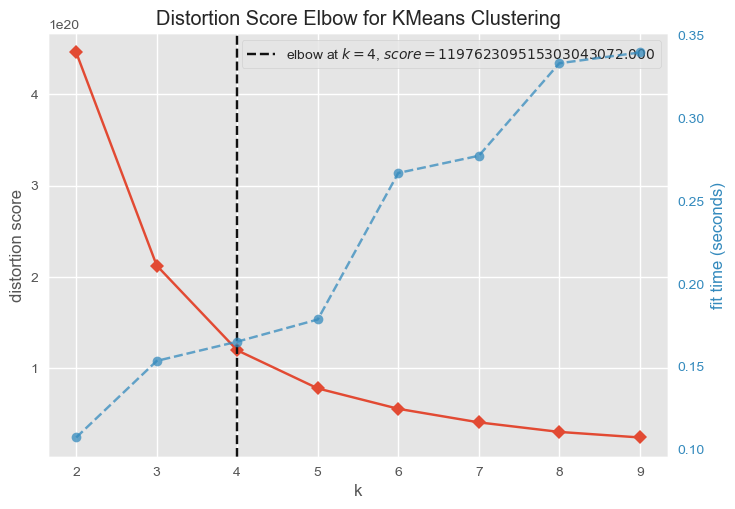

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9), k=(2, 10))

In [144]:
plt.style.use('ggplot')
kelbow_visualizer(KMeans(), X, k=(2,10))

Text(0, 0.5, 'Within Sum of Squares Distance')

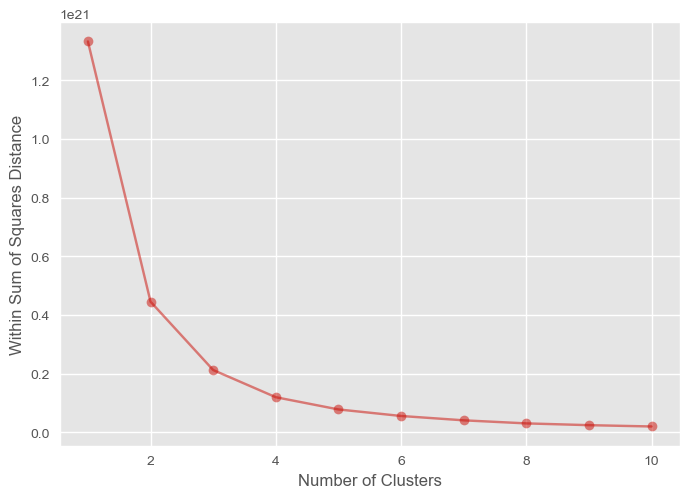

In [145]:
wss=[]

for n in range(1,11):
 kmeans = KMeans(n_clusters=n).fit(X)
 wss.append(kmeans.inertia_)
 
plt.plot(range(1,11),wss,c='r',marker='o',alpha=0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Within Sum of Squares Distance')

In [147]:
n_clusters=4
kmeans = KMeans(n_clusters=n_clusters).fit(X)

pd.DataFrame(kmeans.cluster_centers_,columns=X.columns)


labels=kmeans.labels_
X['clusters']=labels

In [148]:
average_silhouette=silhouette_score(X,labels)
print(average_silhouette)

0.6087879608349401


In [149]:
sample_silhouette_values=silhouette_samples(X,labels)
np.sum(sample_silhouette_values<0)/len(sample_silhouette_values)

0.0008144059361143788

In [150]:
X.groupby('clusters').agg('count')

R     F     M   SKU
clusters                        
0         2992  2992  2992  2992
1         6477  6477  6477  6477
2         1213  1213  1213  1213
3          369   369   369   369

In [151]:
X.groupby('clusters').agg('mean')

R          F             M        SKU
clusters                                               
0         14.924799  13.468249  3.896390e+08  62.114639
1         34.147445   6.949050  1.121017e+08  32.418249
2         10.690849  17.959604  8.288878e+08  81.399835
3         10.349593  20.842818  1.599952e+09  98.525745

# Conclusion:
* 0 : VIP
* 2 : A
* 3 : B
* 1 : C

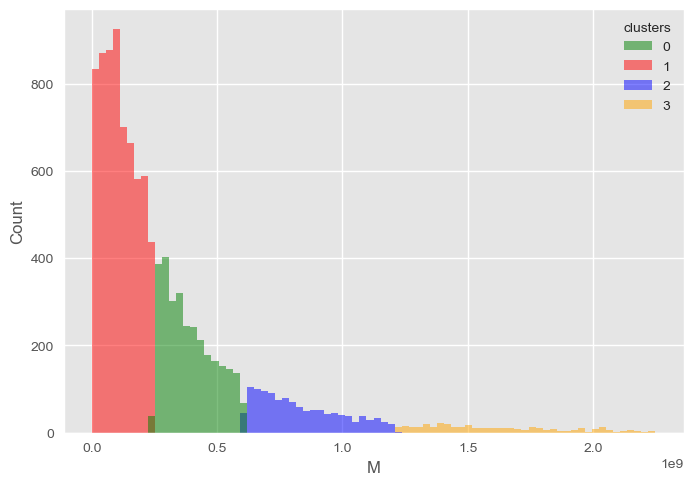

In [152]:
sns.histplot(data=X,x='M',hue='clusters',edgecolor='none',palette=['green','red','blue','orange']);

# It doesn't make sense that 60% of our customer get the lowest grade. That would be because the data set is not scaled and features need to be scaled. Actually, the model tend to consider M as a most important featue in compared to others.

# Try With Scaled data

In [153]:
#With Scale
X=pd.concat((pd.DataFrame(Recency),pd.DataFrame(Frequency),pd.DataFrame(Montery),pd.DataFrame(SKU)),axis=1)
X.columns=['R','F','M',"SKU"]
X=X.loc[X['M']>0,:]
X=X[(np.abs(stats.zscore(X['M']))<5)]

standardize=StandardScaler()
standardize.fit(X)
X=standardize.fit_transform(X)

X=pd.DataFrame(X)
X.columns=['R','F','M',"SKU"]
n_clusters=4
kmeans = KMeans(n_clusters=n_clusters).fit(X)

pd.DataFrame(kmeans.cluster_centers_,columns=X.columns)

R         F         M       SKU
0 -0.158257 -0.535711 -0.459549 -0.542815
1 -0.434593  0.611291  0.207178  0.584702
2  2.502461 -0.959077 -0.558356 -0.883253
3 -0.481282  1.726795  2.358206  1.774993

In [154]:
Xorg=standardize.inverse_transform(X)
Xorg=pd.DataFrame(Xorg)
Xorg.columns=[ 'R', 'F', 'M','SKU']
Xorg['clusters']=kmeans.labels_
Xorg.index=X.index
Xorg.groupby('clusters').count()

R     F     M   SKU
clusters                        
0         5283  5283  5283  5283
1         3687  3687  3687  3687
2         1163  1163  1163  1163
3          983   983   983   983

In [155]:
Xorg.groupby('clusters').agg('mean')

R          F             M         SKU
clusters                                                 
0          19.563506   6.348666  1.513006e+08   30.445391
1           9.104421  15.141307  4.082202e+08   67.575264
2         120.206363   3.102322  1.133762e+08   19.250215
3           7.348932  23.703967  1.236482e+09  106.825025

# Conclusion:
* 3 : VIP
* 1 : A
* 0 : B
* 2 : C

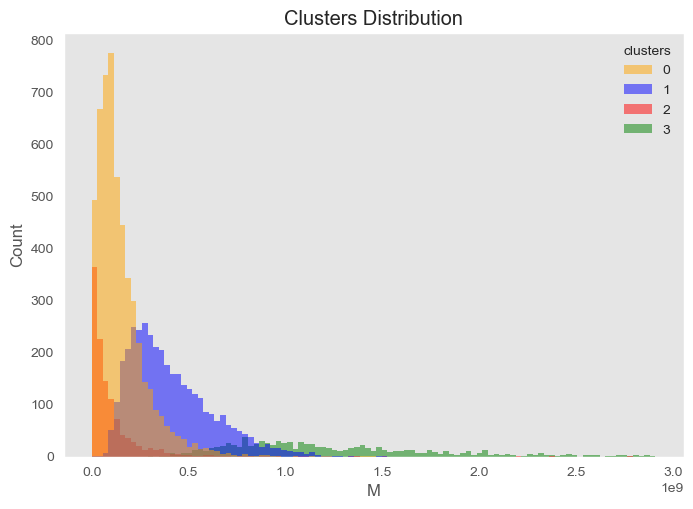

In [158]:
sns.histplot(data=Xorg,x='M',hue='clusters',edgecolor='none',palette=['orange','blue','red','green']).set(title='Clusters Distribution')
plt.grid();

In [159]:
fig = px.scatter_3d(Xorg,x='R',y='F',z='M',size='SKU', color='clusters')

fig.update_layout(width=800, height=800, title = 'Customers Clusters',
                  scene = dict(xaxis=dict(title='Recency', titlefont_color='darkblue'),
                               yaxis=dict(title='Frequency', titlefont_color='darkblue'),
                               zaxis=dict(title='Monetary Value', titlefont_color='darkblue'),
                               bgcolor = 'lightblue'
                           ))
fig.show()
fig.write_html("Downloads/CustomersClusters.html")

In [160]:
fig = px.parallel_coordinates(Xorg, color="clusters",
                              dimensions=['R','F','M','SKU'],
                             color_continuous_midpoint=2)

fig.show()

In [40]:
#save it as a csv file
Xorg.to_csv('E:/GRADECUSTOMER/1401/RFMSKU_new.csv')